<a href="https://colab.research.google.com/github/LuisPerdomo123/Inteligencia-Computacional/blob/main/Keras_Tuner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Keras Tuner

Keras Tuner es una biblioteca que te ayuda a elegir el conjunto óptimo de hiperparámetros para tu programa TensorFlow/keras. El proceso de seleccionar el conjunto correcto de hiperparámetros para su aplicación de aprendizaje automático (ML) se llama hyperparameter tuning o hypertuning.

Los hiperparámetros son las variables que gobiernan el proceso de entrenamiento y la topología de un modelo de Machine Learning. Estas variables permanecen constantes durante el proceso de entrenamiento e impactan directamente en el rendimiento del programa. Los hiperparámetros pueden ser de dos tipos:



*   **Hiperparámetros del modelo** que influyen en la selección del modelo, como el número y el ancho de las hidden layers.
*   **Hiperparámetros del algoritmo** que influyen en la velocidad y la calidad del algoritmo de aprendizaje, como la tasa de aprendizaje para el Descenso de Gradiente Estocástico (SGD).



## 0. Imports

In [2]:
pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.3 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
from tensorflow import keras
import kerastuner as kt

<ipython-input-3-fe85bac8af47>:3: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


## 1. Conjunto de datos

In [4]:
(img_train, label_train), (img_test, label_test) = keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


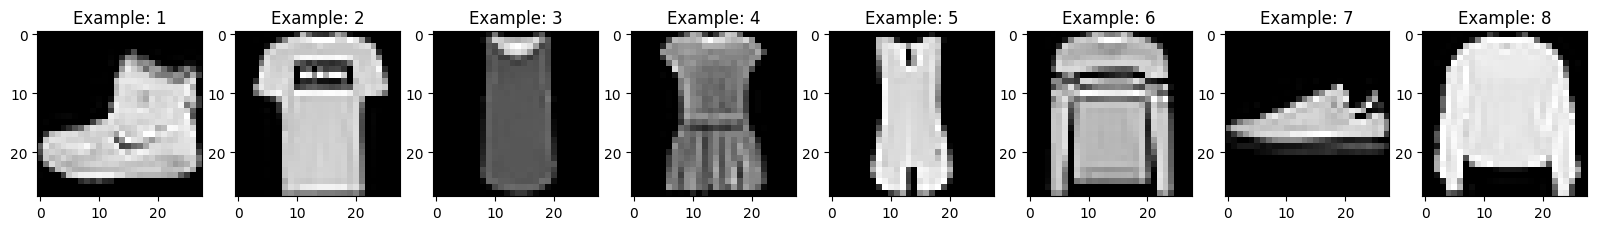

In [7]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 4))

num_examples = min(len(img_train), 8)  # Ensure we don't exceed 8 examples
for index, e in enumerate(img_train[:num_examples]):
    plt.subplot(1, num_examples, index + 1)
    plt.imshow(e, cmap=plt.cm.gray)
    plt.title('Example: ' + str(index + 1))

plt.show()

In [8]:
# Normalizamos el valor de los pixels entre 0 y 1
img_train = img_train.astype('float32')/255.0
img_test = img_test.astype('float32')/255.0

## 2. Definición del modelo

Cuando se construye un modelo para realizar hypertuning, debe definirse el espacio de búsqueda de hiperparámetros además de la arquitectura del modelo. El modelo que estableces para realizar hypertuning se llama hypermodel.

Puedes definir un hypermodel a través de dos enfoques:


*   Implementando una función que construye el modelo.
*   Creando una subclase HyperModel de la Keras Tuner API.

También puedes utilizar dos clases predefinidas de HyperModel. HyperXception y HyperResNet para aplicaciones de visión artificial.

En este tutorial, se implementa una función que construye un modelo de clasificación de imágenes. La función devuelve un modelo compildo y utiliza los hiperparámetros que se definan para realizar hypertuning del mismo.



In [9]:
def model_builder(hp):

  # Definición del modelo
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(28, 28)))

  # Tunning del número de neuronas de la primera hidden layer
  # Seleccionamos el valor óptimo entre 32 y 512
  hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32)
  model.add(keras.layers.Dense(units = hp_units, activation='relu'))

  # Tunning del ratio de aprendizaje para el algoritmo de optimización
  # Seleccionamos el valor óptimo entre [0.01, 0.001, 0.0001]
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])

  model.compile(
      optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
      loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=['accuracy']
  )
  return model

El parámetro hp que recibe la función, se corresponde con un objeto de la clase HyperParameters, que de manera general, se corresponde con un 'almacen' de hiperparámetros.

## 3. Instanciando el objeto Tuner para realizar hypertuning

Una vez definida la función anterior, se instancia el Tuner para realizar el hypertuning. Keras Tuner tiene cuatro tuners disponibles - RandomSearch, Hiperband, BayesianOptimizaion y Sklearn. En este tutorial, se utiliza Huperband(https://arxiv.org/pdf/1603.06560.pdf)

Para instanciar el tuner de Hyperband, hay que especificar el hypermodel, el objetivo a optimizar y el número máximo de epochs a entrenar (max_epochs).

In [10]:
tuner = kt.Hyperband(
    model_builder,
    objective = 'val_accuracy',
    max_epochs = 10,
    factor = 3,
    directory = 'test_dir',
    project_name = 'hp_tuning'
)

El algoritmo Hyperband utiliza adaptativa de recursos y la detenvión temprana para converger rápidamente en un modelo de alto rendimiento. El algoritmo entrena un gran número de modelos durante unos pocos epochs y lleba a la siguiente ronda sólo la mitad de los modelos de mayor rendimiento. Hyperband determina el número de modelos a entrenar mediante la formula 1 + logfactor(max_epochs) y redondea el resultado al entero más cercano.

In [11]:
# Ejecución del tuner para la búsqueda de hiperparámetros
tuner.search(
    img_train,
    label_train,
    epochs = 10,
    validation_data = (img_test, label_test)
)

Trial 30 Complete [00h 02m 23s]
val_accuracy: 0.7064999938011169

Best val_accuracy So Far: 0.8453999757766724
Total elapsed time: 00h 24m 31s


Una vez que hemos realizado la búsqueda de los hiperparámetros podemos acceder a los valores óptimos mediante la siguiente sentencia

In [12]:
# Obtención de los hiperparámetros óptimos
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print("Units: ", best_hps.get('units'))
print("Learning rate: ", best_hps.get('learning_rate'))

Units:  288
Learning rate:  0.001


## 5. Entrenamiento del modelo

Una vez seleccionados los hiperparámetros óptimos, los utilizamos para entrenar el modelo.

In [13]:
model = tuner.hypermodel.build(best_hps)

history = model.fit(
    img_train,
    label_train,
    epochs = 10,
    validation_data = (img_test, label_test)
)

Epoch 1/10
1875/1875 [==============================] - 12s 6ms/step - loss: 1.3123 - accuracy: 0.7164 - val_loss: 1.1430 - val_accuracy: 0.7411
Epoch 2/10
1875/1875 [==============================] - 12s 6ms/step - loss: 1.0812 - accuracy: 0.7571 - val_loss: 1.1004 - val_accuracy: 0.7434
Epoch 3/10
1875/1875 [==============================] - 12s 6ms/step - loss: 1.0386 - accuracy: 0.7629 - val_loss: 1.0669 - val_accuracy: 0.7473
Epoch 4/10
1875/1875 [==============================] - 11s 6ms/step - loss: 1.0171 - accuracy: 0.7674 - val_loss: 1.0533 - val_accuracy: 0.7498
Epoch 5/10
1875/1875 [==============================] - 11s 6ms/step - loss: 1.0009 - accuracy: 0.7699 - val_loss: 1.0411 - val_accuracy: 0.7551
Epoch 6/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.9924 - accuracy: 0.7711 - val_loss: 1.0301 - val_accuracy: 0.7575
Epoch 7/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.9840 - accuracy: 0.7717 - val_loss: 1.0532 - val_ac

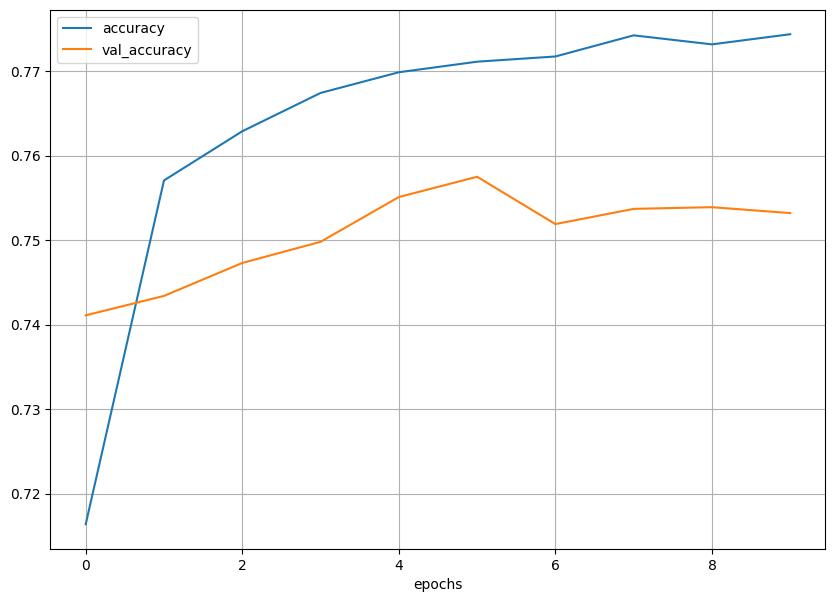

In [14]:
import pandas as pd

pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot(figsize=(10, 7))
plt.grid(True)
plt.xlabel("epochs")
plt.show()